In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('web_App_home_book1.csv',index_col='Check_in',parse_dates=True)
df.index.freq='MS'

In [4]:
df.head()

,Rent
Check_in,
2020-01-01,111900
2020-02-01,37400
2020-03-01,13300
2020-04-01,18400
2020-05-01,11600


<Axes: xlabel='Check_in'>

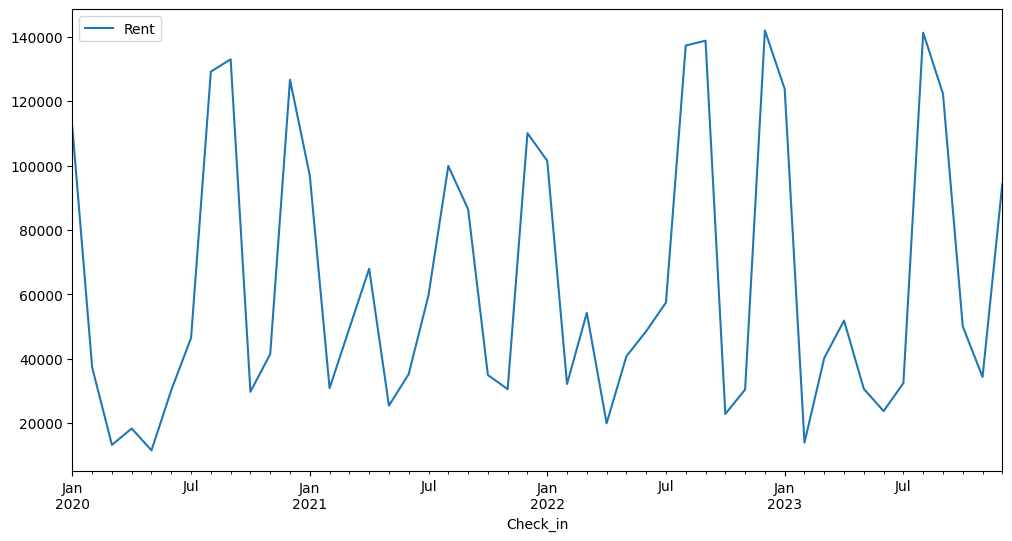

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

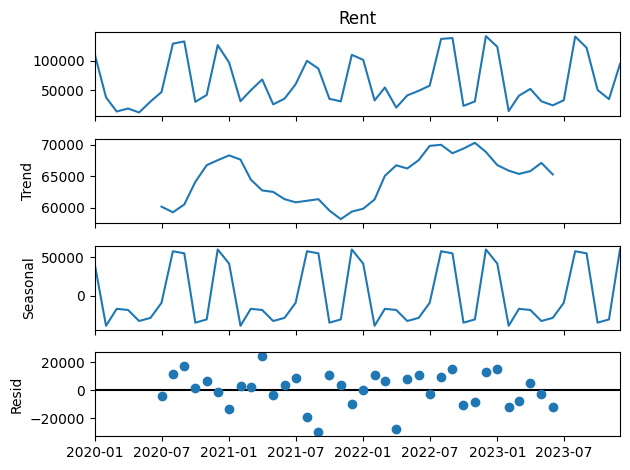

In [7]:
results = seasonal_decompose(df['Rent'])
results.plot();

In [8]:
len(df)

48

In [9]:
train = df.iloc[:36]
test = df.iloc[36:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
df.head(),df.tail()

(              Rent
 Check_in          
 2020-01-01  111900
 2020-02-01   37400
 2020-03-01   13300
 2020-04-01   18400
 2020-05-01   11600,
               Rent
 Check_in          
 2023-08-01  141300
 2023-09-01  122300
 2023-10-01   50100
 2023-11-01   34400
 2023-12-01   94400)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
scaled_train[:10]

array([[0.76917178],
       [0.19785276],
       [0.01303681],
       [0.05214724],
       [0.        ],
       [0.14340491],
       [0.26763804],
       [0.90184049],
       [0.9309816 ],
       [0.13957055]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [16]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.76917178 0.19785276 0.01303681 0.05214724 0.         0.14340491
 0.26763804 0.90184049 0.9309816  0.13957055 0.22929448 0.88266871]
Predict this y: 
 [[0.6541411]]


In [17]:
X.shape

(1, 12, 1)

In [18]:
# We do the same thing, but now instead for 12 months
n_input = 36
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50

24/24 [==============================] - 2s 6ms/step - loss: 0.1420
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0947
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0987
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0952
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0949
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0932
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0884
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0992
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0899
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0912
Epoch 13/50
24/24 [=============================

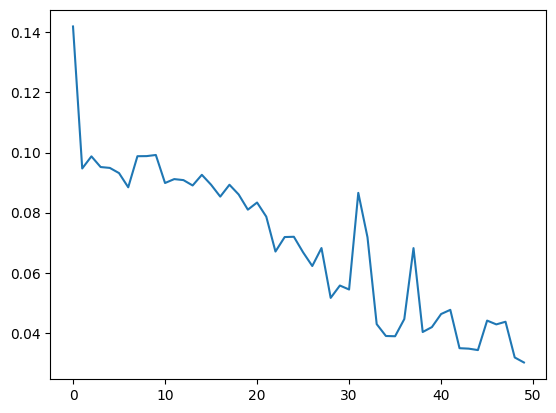

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-12:]

In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 346ms/step


array([[0.66584706]], dtype=float32)

In [27]:
scaled_test[0]

array([0.86042945])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 20ms/step


In [37]:
test_predictions

[array([0.66584706], dtype=float32),
 array([0.21042818], dtype=float32),
 array([0.24479066], dtype=float32),
 array([0.20480676], dtype=float32),
 array([0.21791203], dtype=float32),
 array([0.2694316], dtype=float32),
 array([0.50556505], dtype=float32),
 array([0.88480324], dtype=float32),
 array([0.79383934], dtype=float32),
 array([0.20975363], dtype=float32),
 array([0.24418965], dtype=float32),
 array([0.84480697], dtype=float32)]

In [30]:
test.head()

,Rent
Check_in,
2023-01-01,123800
2023-02-01,14000
2023-03-01,40300
2023-04-01,51900
2023-05-01,30700


In [32]:
true_predictions = scaler.inverse_transform(test_predictions)

In [33]:
test['Predictions'] = true_predictions

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16092\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Check_in'>

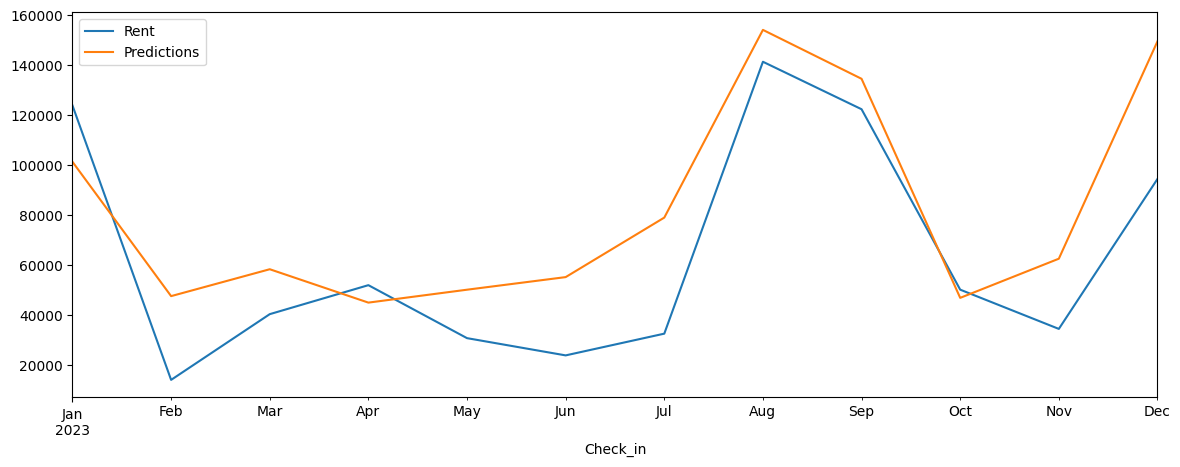

In [71]:
test.plot(figsize=(14,5))

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Rent'],test['Predictions']))
print(rmse)

28372.541508913655
